# Ultimate Technologies Inc. Take-Home Challenge

Ultimate Technologies Inc. is a transportation network company that has disrupted the taxi and logistics industry and is considered a prestigious company to work for.

This notebook includes three part to complete the challenge.
  - Exploratory data analysis
  - Experiment and metrics design
  - Predictive modeling

## Load the libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import accuracy_score
from scipy.stats import randint 

import warnings
warnings.filterwarnings("ignore")

## Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

**Observation**
  - The Logins data has a weekly cycle patterns.
  - Logins most occur on weekend, especially on Saturday. Logins occur on Monday least.
  - Logins most occur around 10pm to 2am and decrease after 1am, then it has a lowest piont around 7am to 8am in the morning. Logins stated increace again after 8am, then have another peek at 11am lunch time.

In [2]:
# load the data
df = pd.read_json('logins.json')
df.head()

login_time
0 1970-01-01 20:13:18
1 1970-01-01 20:16:10
2 1970-01-01 20:16:37
3 1970-01-01 20:16:36
4 1970-01-01 20:26:21

In [3]:
# check the information of data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


No missing data, so there is no need data wrangling.

In [4]:
# check the minimal and maxmial time
print("Minimal time: {}".format(df.login_time.min()))
print("Maximal time: {}".format(df.login_time.max()))

Minimal time: 1970-01-01 20:12:16
Maximal time: 1970-04-13 18:57:38


### 1.1 Aggregate login counts based on 15minute time intervals

In [5]:
# Aggregate these login counts based on 15minute time intervals
df = df.groupby(pd.Grouper(key='login_time', freq='15min')).size()
# to dataframe
df = df.to_frame(name='count')
df.head()

count
login_time                
1970-01-01 20:00:00      2
1970-01-01 20:15:00      6
1970-01-01 20:30:00      9
1970-01-01 20:45:00      7
1970-01-01 21:00:00      1

### 1.2 Visualizition

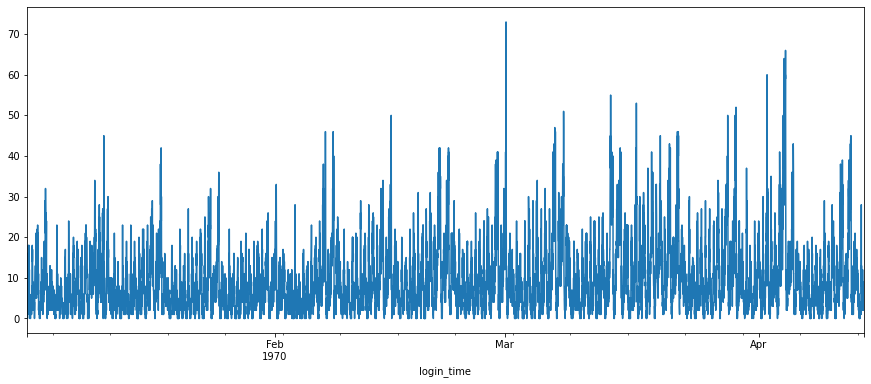

In [6]:
# let's first visaulize the entire data
plt.figure(figsize=(15,6))
df['count'].plot()

There's seem a cycle patterns. Let's explore more.

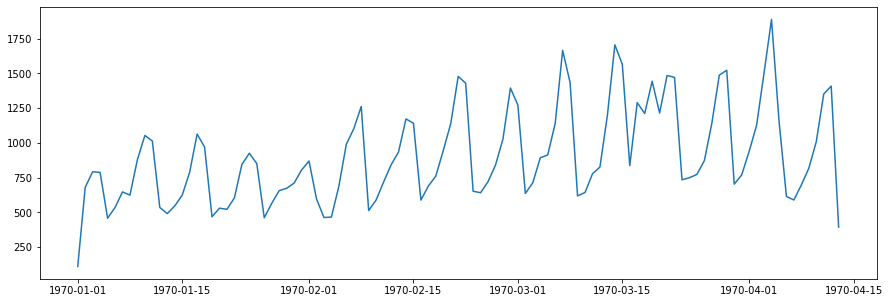

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df.resample('D').sum())

Here, we do see a weekly cycle patterns. Let's take a closer look at the daily and hourly trend.


In [8]:
# add the weekday column with Monday through Sunday and hour column
df = df.reset_index()
df['weekday']=df.login_time.dt.day_name()
df['hour'] = df.login_time.dt.hour
df.head()

login_time  count   weekday  hour
0 1970-01-01 20:00:00      2  Thursday    20
1 1970-01-01 20:15:00      6  Thursday    20
2 1970-01-01 20:30:00      9  Thursday    20
3 1970-01-01 20:45:00      7  Thursday    20
4 1970-01-01 21:00:00      1  Thursday    21

#### Daily trend by week

In [9]:
daily = df[['weekday', 'count']].groupby('weekday', as_index=False).sum()
daily

weekday  count
0     Friday  15208
1     Monday   8823
2   Saturday  19377
3     Sunday  18167
4   Thursday  11960
5    Tuesday   9268
6  Wednesday  10339

In [10]:
weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

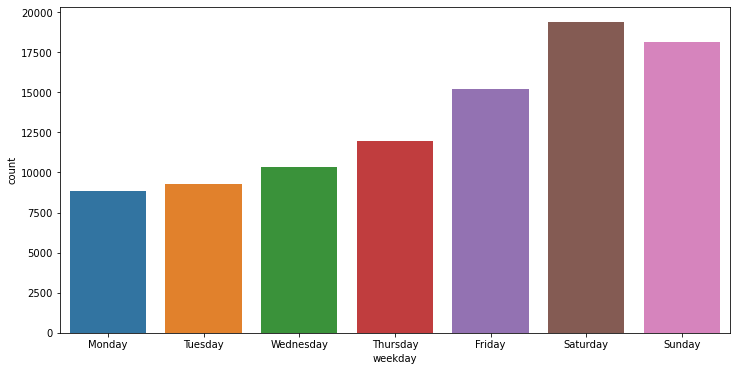

In [11]:
plt.figure(figsize=(12,6))
sns.barplot(x='weekday', y='count', data=daily, order=weekday)

Logins most occur on weekend, especially on Saturday. Logins occur on Monday least. 

#### Trend by hour

In [12]:
hour = df.groupby('hour', as_index=False).sum()
hour.head()

hour  count
0     0   5993
1     1   6317
2     2   5800
3     3   4831
4     4   5034

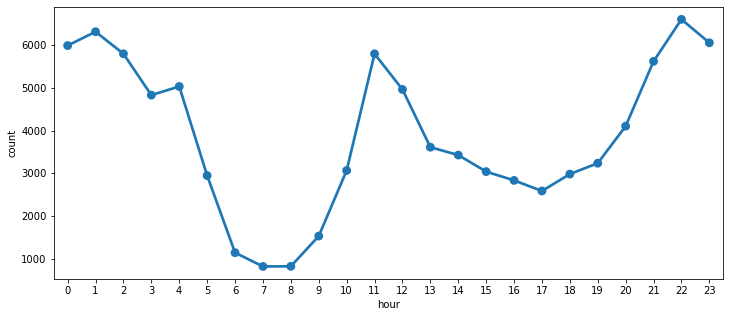

In [13]:
plt.figure(figsize=(12,5))
sns.pointplot(x='hour', y='count', data=hour)

Logins most occur around 10pm to 2am and decrease after 1am, then it has a lowest piont around 7am to 8am in the morning. Logins stated increace again after 8am, then have another peek at 11am lunch time.

## Part 2 ‑ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

> A: We can check driver parters spending time difference between before and after experiment to check if the experiment encourage driver partners to travel in both city. Then We can check the customer waiting time to check if the experiment works better than before. Last, we can check the revenue difference to check if the experiment could benefit the company.

2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:  
    a. how you will implement the experiment  
    > A: To implement the experiment, I will measure the key measures above for a season and compare if there are significance difference to the same season from last year. 
    
    b. what statistical test(s) you will conduct to verify the significance of the observation  
    > A: I will perform the t-test with 0.05 as significance level for the hypothesis tesing.  
    
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.   
    > A: If driver parters spending time tend to equal in both cities that means the experiment is working. If the waiting time decreased that means the experiment is reasonable. If the seasonal revenue increased  that means this experements works better and benefit the company.

## Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice).

**Data description**  
  - city: city this user signed up in
  - phone: primary device for this user
  - signup_date: date of account registration; in the form ‘YYYY MM DD’
  - last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
  - avg_dist: the average distance in miles per trip taken in the first 30 days after signup
  - avg_rating_by_driver: the rider’s average rating over all of their trips
  - avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
  - surge_pct: the percent of trips taken with surge multiplier > 1
  - avg_surge: The average surge multiplier over all of this user’s trips
  - trips_in_first_30_days: the number of trips this user took in the first 30 days after signing up
  - ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days; FALSE otherwise
  - weekday_pct: the percent of the user’s trips occurring during a weekday

In [14]:
# load the data
df_ult = pd.read_json('ultimate_data_challenge.json')
df_ult.head()

city  trips_in_first_30_days signup_date  avg_rating_of_driver  \
0  King's Landing                       4  2014-01-25                   4.7   
1         Astapor                       0  2014-01-29                   5.0   
2         Astapor                       3  2014-01-06                   4.3   
3  King's Landing                       9  2014-01-10                   4.6   
4      Winterfell                      14  2014-01-27                   4.4   

   avg_surge last_trip_date    phone  surge_pct  ultimate_black_user  \
0       1.10     2014-06-17   iPhone       15.4                 True   
1       1.00     2014-05-05  Android        0.0                False   
2       1.00     2014-01-07   iPhone        0.0                False   
3       1.14     2014-06-29   iPhone       20.0                 True   
4       1.19     2014-03-15  Android       11.8                False   

   weekday_pct  avg_dist  avg_rating_by_driver  
0         46.2      3.67                   5.0  
1         50.0      8.26                   5.0  
2        100.0      0.77                   5.0  
3         80.0      2.36                   4.9  
4         82.4      3.13                   4.9

### 3.1 Data wrangling

In [15]:
df_ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


#### 3.1.1 Parse to datetime variable

In [16]:
# parse to datetime variables
df_ult['last_trip_date'] = pd.to_datetime(df_ult['last_trip_date'])
df_ult['signup_date'] = pd.to_datetime(df_ult['signup_date'])

#### 3.1.2 Handling the missing data

In [17]:
# check the percentage of nan values
percent_missing = df_ult.isnull().sum() * 100 / len(df_ult)
percent_missing

city                       0.000
trips_in_first_30_days     0.000
signup_date                0.000
avg_rating_of_driver      16.244
avg_surge                  0.000
last_trip_date             0.000
phone                      0.792
surge_pct                  0.000
ultimate_black_user        0.000
weekday_pct                0.000
avg_dist                   0.000
avg_rating_by_driver       0.402
dtype: float64

There is around 16% missing data on avg_rating_of_driver feature. So we can't just drop the missing data. Let's try to fill in the missing data. 

In [18]:
# avg_rating_of_driver
df_ult.avg_rating_of_driver.describe()

count    41878.000000
mean         4.601559
std          0.617338
min          1.000000
25%          4.300000
50%          4.900000
75%          5.000000
max          5.000000
Name: avg_rating_of_driver, dtype: float64

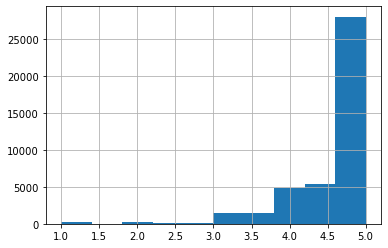

In [19]:
df_ult.avg_rating_of_driver.hist()

In [20]:
# avg_rating_by_driver
df_ult.avg_rating_by_driver.describe()

count    49799.000000
mean         4.778158
std          0.446652
min          1.000000
25%          4.700000
50%          5.000000
75%          5.000000
max          5.000000
Name: avg_rating_by_driver, dtype: float64

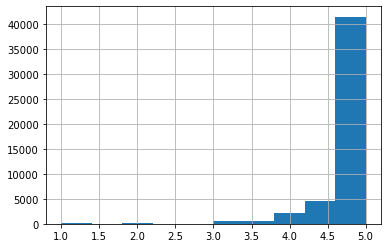

In [21]:
df_ult.avg_rating_by_driver.hist()

In [22]:
# phone
df_ult.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

From the describe and histgrame figure of avg_rating_by_driver and avg_rating_by_driver, we can see that there'er long tails on the left. In order to avoid the impact from the outliers, I'll fill in the missing data with median value for them. 

We also see that iphone appear much more than Andriod phone. Here I will fill in the missing data with the iphone for phone feature.

In [23]:
df_ult['avg_rating_of_driver'] = df_ult['avg_rating_of_driver'].fillna(df_ult['avg_rating_of_driver'].median())
df_ult['avg_rating_by_driver'] = df_ult['avg_rating_by_driver'].fillna(df_ult['avg_rating_by_driver'].median())
df_ult['phone'] = df_ult['phone'].fillna('iPhone')

In [24]:
df_ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    50000 non-null  object        
 1   trips_in_first_30_days  50000 non-null  int64         
 2   signup_date             50000 non-null  datetime64[ns]
 3   avg_rating_of_driver    50000 non-null  float64       
 4   avg_surge               50000 non-null  float64       
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   50000 non-null  object        
 7   surge_pct               50000 non-null  float64       
 8   ultimate_black_user     50000 non-null  bool          
 9   weekday_pct             50000 non-null  float64       
 10  avg_dist                50000 non-null  float64       
 11  avg_rating_by_driver    50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

### 3.2 Exploratory data analysis

#### 3.2.1 The fraction of the observed users were retained.
we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

In [25]:
# check the data of data was taken from the last trip date in the dataset
sorted(df_ult['last_trip_date'])[-5:]

[Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00'),
 Timestamp('2014-07-01 00:00:00')]

It looks like the date of data was taken was 1st July, 2014. So a user will be considered as a retaind if he/she took a ride after 1st June, 2014.

In [26]:
# add a column for retaind
df_ult['retained'] = df_ult['last_trip_date'].apply(lambda x: 1 if x >= pd.Timestamp('2014-06-01', tz=None) else 0)

In [27]:
df_ult.retained.value_counts()

0    31196
1    18804
Name: retained, dtype: int64

In [28]:
# Calculate the fraction of the observed users were retained
retain_rate = len(df_ult[df_ult['retained'] == 1])/len(df_ult)*100
print('The fraction of the observed users were retained is: {}%'.format(round(retain_rate, 2)))

The fraction of the observed users were retained is: 37.61%


#### 3.2.2 Explore data relationships

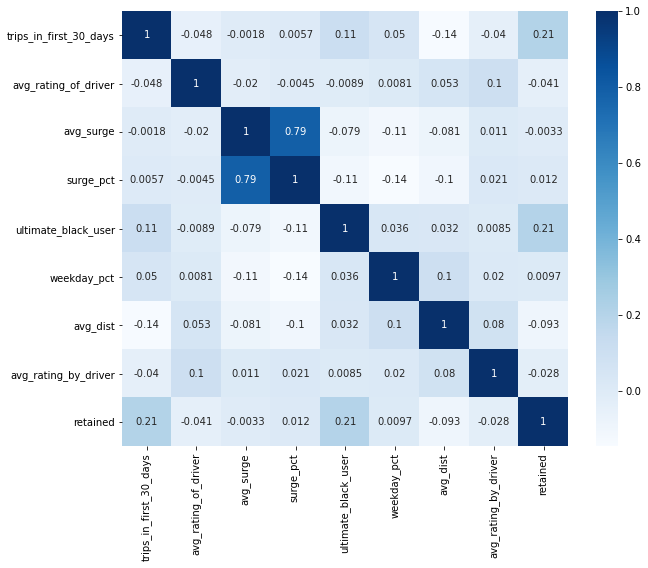

In [29]:
# check the relationships with heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df_ult.corr(), annot=True,cmap ='Blues')

We observe the strong relationship between avg_surge and surge_pct, so we can drop surge_pct for later modeling building.

In [30]:
# Drop 'surge_pct' column.
drop_cols = ['surge_pct']
df_ult = df_ult.drop(drop_cols, axis=1)

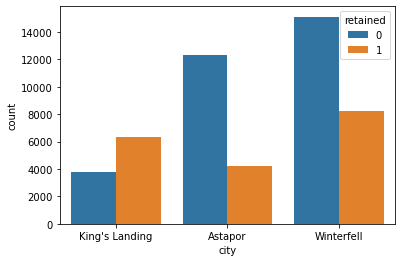

In [31]:
# Let's check the relationship between object feature and retained user.
# city and retained user
sns.countplot(x='city', data=df_ult, hue='retained')

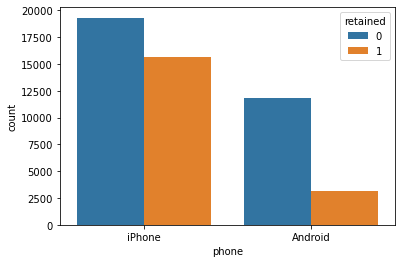

In [32]:
# phone and retained user
sns.countplot(x='phone', data=df_ult, hue='retained')

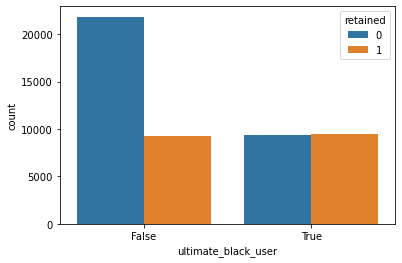

In [33]:
# ultimate_black_user and retained user
sns.countplot(x='ultimate_black_user', data=df_ult, hue='retained')

Here, we can observe that the percentage of retained users are different between citis, phones and ultimate_black_user. Here, we will use those features for later model building. 

### 3.3 Pre-processing and Training Data Development

We want to build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. So we need to identify the active users if he/she took a trip in the 6th month on the system. Then we can use the active users column to build a supervised machine learning model to make a prediction. Because all users in the dataset was signed up for an Ultimate account in January 2014 and the the day of date got was in July 2014, the retained feature we just builed can be used for the active users for model building.

#### 3.3.1 Drop unusefull features

In [34]:
# Drop 'last_trip_date' and 'signup_date' beacause we use them to indicate the retained column.
drop_cols = ['last_trip_date', 'signup_date']
df_ult = df_ult.drop(drop_cols, axis=1)

In [35]:
df_ult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   avg_rating_of_driver    50000 non-null  float64
 3   avg_surge               50000 non-null  float64
 4   phone                   50000 non-null  object 
 5   ultimate_black_user     50000 non-null  bool   
 6   weekday_pct             50000 non-null  float64
 7   avg_dist                50000 non-null  float64
 8   avg_rating_by_driver    50000 non-null  float64
 9   retained                50000 non-null  int64  
dtypes: bool(1), float64(5), int64(2), object(2)
memory usage: 3.5+ MB


#### 3.3.2 Train/test split

In [36]:
# compute the boolean column ultimate_black_user to numerical.
df_ult['ultimate_black_user'] = df_ult['ultimate_black_user'].apply(lambda x: 1 if x else 0)

In [37]:
# Make an explanatory variable called X with all the remainning features
X = df_ult[df_ult.columns[:-1]]

# Make a dependent variable called y with retained column
y = df_ult[df_ult.columns[-1]]

In [38]:
# split features and target into train and test sets
# Call train_test_split on X, y. Make the test_size = 0.25, and random_state = 246
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 246)

In [39]:
# One-hot encode all features in training set.
X_train = pd.get_dummies(X_train, drop_first=True)

# Do the same, but for X_test
X_test = pd.get_dummies(X_test, drop_first=True)

In [40]:
X_train.head()

trips_in_first_30_days  avg_rating_of_driver  avg_surge  \
22289                       1                   4.9       1.00   
15322                       1                   1.0       1.00   
23424                       0                   3.2       1.00   
30641                       0                   3.0       1.00   
11586                       3                   3.8       1.19   

       ultimate_black_user  weekday_pct  avg_dist  avg_rating_by_driver  \
22289                    0          0.0      1.53                   4.0   
15322                    0        100.0      8.51                   5.0   
23424                    1         60.0     10.02                   4.3   
30641                    1        100.0      6.78                   5.0   
11586                    0         25.0      2.53                   4.5   

       city_King's Landing  city_Winterfell  phone_iPhone  
22289                    0                0             1  
15322                    0                1             0  
23424                    1                0             1  
30641                    0                1             1  
11586                    1                0             1

In [41]:
print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(37500, 10) (37500,)
(12500, 10) (12500,)


### 3.4 Modeling

Here, I will build a Random Forest Classifier model to do the prediction. I used random search for the best hyperparameter. 

#### 3.4.1 Random Search Hyperparameter optimization

In [42]:
param_dist = {'criterion': ['entropy', 'gini'],
               'max_depth': list(np.linspace(10, 1200, 10, dtype = int)) + [None],
               'max_features': randint(1, 11),
               'min_samples_leaf': randint(1, 11),
               'min_samples_split': randint(2, 20),
               'n_estimators': list(np.linspace(10, 120, 10, dtype = int))}
# Run Randomized Search
rfc = RandomForestClassifier()
model = RandomizedSearchCV(estimator = rfc, param_distributions = param_dist, n_iter = 10, 
                               cv = 4, verbose= 5, random_state= 101, n_jobs = -1)
model.fit(X_train, y_train)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   59.3s finished


RandomizedSearchCV(cv=4, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

**Print the best score and best parameter**

In [43]:
# Print the best score and best parameter
print("Best Score:" + str(model.best_score_))
print("Best Parameters: " + str(model.best_params_))

Best Score:0.7818133333333334
Best Parameters: {'criterion': 'gini', 'max_depth': 406, 'max_features': 3, 'min_samples_leaf': 9, 'min_samples_split': 12, 'n_estimators': 95}


In [44]:
###table = pd.pivot_table(pd.DataFrame(model.cv_results_),
#    values='mean_test_score', index='param_n_estimators', 
#                       columns='param_criterion')
#table

#### 3.4.2 Model Evaulation

In [45]:
predictionforest = model.best_estimator_.predict(X_test)
print(confusion_matrix(y_test,predictionforest))
print(classification_report(y_test,predictionforest))
acc3 = accuracy_score(y_test,predictionforest)

[[6655 1089]
 [1599 3157]]
              precision    recall  f1-score   support

           0       0.81      0.86      0.83      7744
           1       0.74      0.66      0.70      4756

    accuracy                           0.78     12500
   macro avg       0.77      0.76      0.77     12500
weighted avg       0.78      0.78      0.78     12500



The accuracy in the Random Forest Classifier is 77%. 

### 3.5 Plot feature importances
Plotting the feature importances is one way that you can gain a perspective on which features are driving the model predictions.

In [46]:
# Random Forest Classifier
rfc = RandomForestClassifier(n_estimators=95, 
                             min_samples_leaf=9,
                             min_samples_split=12, 
                             criterion='gini', 
                             max_features=3,
                             max_depth=406)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=406, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=9, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=95,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

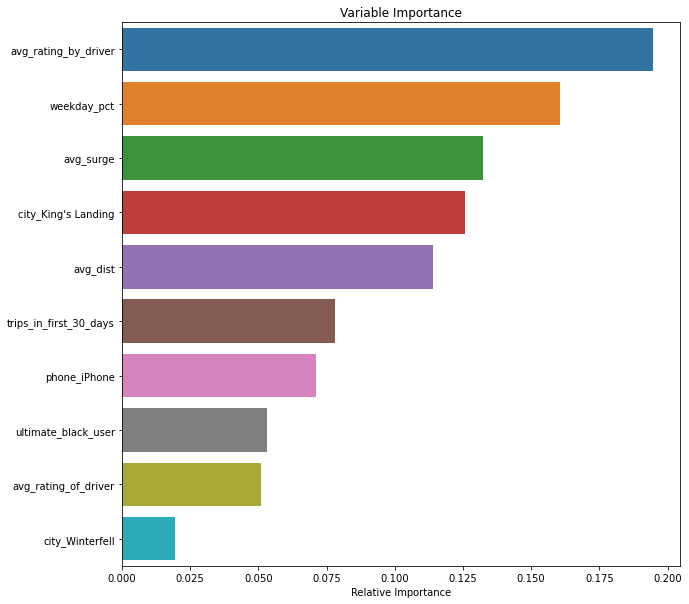

In [47]:
feature_importance = rfc.feature_importances_

df_importances = pd.DataFrame(feature_importance, index=X_train.columns, columns=["Importance"])
df_importances = df_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,10))
sns.barplot(y=df_importances.index, x='Importance', data=df_importances)

plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

### 3.6 Discussion

From the model results, we obtained 77% accuracy. From the feature importance checking, avg_rating_by_driver and weekday_pct are most impontant features.